In [1]:
class Region:
    def __init__(self,x,y):
        self.pixels = [(x, y)]
        self.min_x = x
        self.min_y = y
        self.max_x = x
        self.max_y = y
    
    def add(self, x, y):
        self.pixels.append((x, y))
        self.min_x = min(self.min_x, x)
        self.max_x = max(self.max_x, x)
        self.min_y = min(self.min_y, y)
        self.max_y = max(self.max_y, y)

    def box(self):
        return [(self.min_x, self.min_y), (self.max_x, self.max_y)]

In [2]:
import numpy as np
def morph(matrix, operator=np.min,nx = 3,ny=3):
    new_matrix = np.zeros(matrix.shape)
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            neighbours_list = matrix[max(x-nx, 0) : min(x+nx+1, matrix.shape[0]), \
                                     max(y-ny, 0) : min(y+ny+1, matrix.shape[1])]
            new_matrix[x,y] = operator(neighbours_list)
    return new_matrix

In [3]:
def find_char_regions_naive(img,div_color):

    width, height  = img.shape[:2]
    #Create matrix with reserved space area as img
    region_matrix = [[0 for y in range(height)] for x in range(width)]
    region_matrix = np.zeros(img.shape[:2])
    equivalence_regions = {}
    #count regions
    n_regions = 0
    
    for x in range(width):
        for y in range(height):
            #look for darkish pixeles
            if (img[x, y] >=[0, 0, 0]).all() and (img[x, y]< div_color).all():
                # get the region number from north (up) or west (left) or create new region
                region_w = region_matrix[x-1][y] if x > 0 else 0
                region_n = region_matrix[x][y-1] if y > 0 else 0 
                
                
                max_region = max(region_n, region_w) 
                
                #check if any region exists
                if max_region > 0:
                    
                    #get the oldest region (return same region if only one region)
                    region_num = min(filter(lambda i: i > 0, (region_n, region_w)))            
                    
                    '''if both neighbours have regions take the smallest
                    one(which is the oldest) and put it
                    in the max region neighbour equivalences.
                    because the max should encompass the small.
                    
                    if the max region isn't bigger it means
                    that it was the only one found and it is
                    comparing against itself so it shouldn't
                    add itself to it's equivalances '''
                    
                    if max_region > region_num:
                        if max_region in equivalence_regions:
                            equivalence_regions[max_region].add(region_num)
                        else:
                            #create new set for this existing region
                            equivalence_regions[max_region] = set((region_num,))
                    
                    #there is only one region so do nothing because
                    #it is already assigned in region_num var
                    else:
                        pass
                
                else: 
                    #new region was found so increment by 1 num of regions
                    #and set it to region_num var
                    n_regions += 1
                    region_num = n_regions

                region_matrix[x][y] = region_num 
                
    regions = {} 
    #Scan matrix_regions and assign all equivalent regions the
    #same region value so they unite
    for x in range(width):
        for y in range(height):
                region_num = region_matrix[x][y]
                if region_num > 0:
                    #traverse backward from eql to eql until first
                    while region_num in equivalence_regions:
                        region_num = min(equivalence_regions[region_num])


                    # add region if not inserted previously or update it with new X,Y
                    if region_num not in regions:
                        regions[region_num] = Region(x, y)
                    else:
                        regions[region_num].add(x, y)

    return list(regions.items())


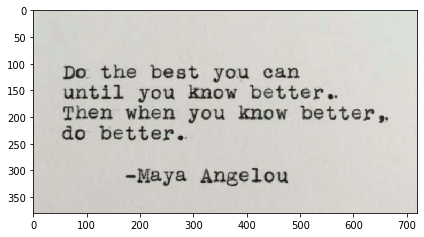

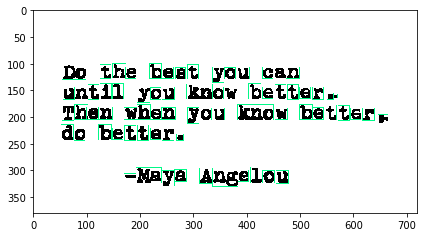

In [4]:
import os,sys

%matplotlib inline
from skimage import io
from skimage.draw import rectangle_perimeter
from skimage.transform import resize
np.set_printoptions(threshold=sys.maxsize) 

filename = r"/home/a/Desktop/Maya-Angelou-quote-720x380.jpg"

img = io.imread(filename)
io.imshow(img) 
io.show()

img =img[:,:,:3]/255
lightest_color = img.reshape((img.shape[0]*img.shape[1], 3)).max(axis=0)
div_color = lightest_color/2
img = morph(img,lambda x: 0 if (x<div_color).any() else 1,1,1)  #dialate
regions = find_char_regions_naive(img,div_color) 
for region in regions:
    #get rectangle perimeter
    x, y = rectangle_perimeter(region[1].box()[0], end=region[1].box()[1])
    #replace values on perimeter with green marking
    img[x-1,y-1] = [0/255,249/255,135/255]
io.imshow(img) 
